In [1]:
%pip install llama-index llama-index-embeddings-ollama ollama pypdf #pypdf to extract text from pdfs, and Ollama is the LLM server, 
%pip install llama-index llama-index-llms-ollama llama-index-embeddings-ollama
import os #manage file paths and create directories
import os.path
import matplotlib.pyplot as plt #visualize text length per page in PDFs
from PyPDF2 import PdfReader #extract text from PDFs
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Settings
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.core.storage.docstore import SimpleDocumentStore
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import ServiceContext
from pypdf import PdfReader

llm = Ollama(model="deepseek-r1:latest") 
Settings.llm = llm

embedding_model = OllamaEmbedding(model_name="nomic-embed-text:latest") 
Settings.embed_model = embedding_model 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [ ]:
PDF_DIR = "./pdfs" #to help us later find the directions of the files, and it contains the original PDFs
CLEANED_TEXT_DIR = "./cleaned_text"  #folder to save cleaned text files

documents = {doc.metadata['file_name']: doc.text for doc in SimpleDirectoryReader("pdfs").load_data()} #load the PDFs from the directory

#make sure if the cleaned text directory really exists
os.makedirs(CLEANED_TEXT_DIR, exist_ok=True)

pdf_files = { #since there is multiple files, we will use a dictionary to store the file names
    "Critical-Systems-Cybersecurity-Controls": os.path.join(PDF_DIR, "Critical-Systems-Cybersecurity-Controls.pdf"),
    "Data-Cybersecurity-Controls": os.path.join(PDF_DIR, "Data-Cybersecurity-Controls-.pdf"),
    "NCS": os.path.join(PDF_DIR, "ncs_en.pdf"),
    "OTCC": os.path.join(PDF_DIR, "otcc_en.pdf")
}

In [3]:
#function to extract text from each PDF and count words per page
def extract_text_and_analyze(pdf_path):
    reader = PdfReader(pdf_path)  #open the PDF file
    page_texts = []  #store text from each page
    text_lengths = []  #store word count per page
    
    #counts words per page to help identify short paragraph pages to skip
    for page in reader.pages:
        text = page.extract_text() 
        if text:
            page_texts.append(text.strip())
            text_lengths.append(len(text.split())) #split the text into words and count them
        else:
            page_texts.append("") #if no text, add empty string
            text_lengths.append(0)
    
    return page_texts, text_lengths

### Step 1: Extract text and analyze page lengths for all PDFs

In [ ]:
text_data = {}  #store extracted text
length_data = {}  #store word counts per page


for name, path in pdf_files.items():
    texts, lengths = extract_text_and_analyze(path)
    text_data[name] = texts
    length_data[name] = lengths

### Step 2: Plot the word count per page for analysis

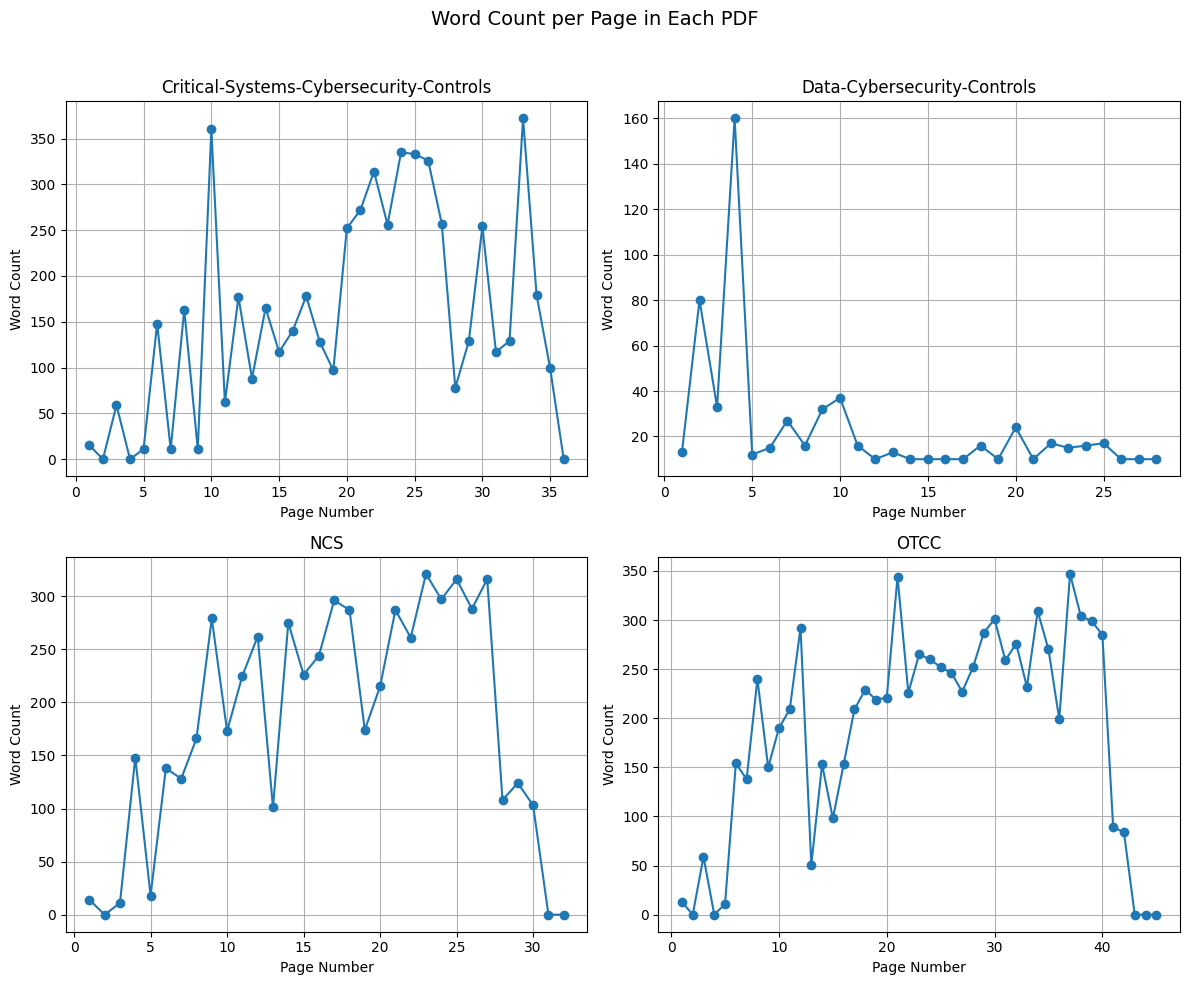

In [18]:
#visualize text distribution to determine which short pages we can skip 

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Word Count per Page in Each PDF", fontsize=14)

for ax, (name, lengths) in zip(axs.flatten(), length_data.items()):
    ax.plot(range(1, len(lengths) + 1), lengths, marker="o", linestyle="-")
    ax.set_title(name)
    ax.set_xlabel("Page Number")
    ax.set_ylabel("Word Count")
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [19]:
#manually set the minimum word count for keeping pages (based on the plot)

min_words_per_pdf = {
    "Critical-Systems-Cybersecurity-Controls": 50, 
    "Data-Cybersecurity-Controls": 10,
    "NCS": 40,
    "OTCC": 65
}

In [20]:
#function to clean and filter PDF text based on word count rules
def clean_pdf_text(name, texts, lengths):
    cleaned_texts = []
    min_words = min_words_per_pdf.get(name, 50)  #default to 50 if no value is set

    print(f"Applying min_words = {min_words} for {name}")

    skip_next = False  #to skip the first page after the title

    for i, (text, length) in enumerate(zip(texts, lengths)):
        # Rule 1: Skip the first page AFTER the title page
        if i == 1:
            skip_next = True
            continue
        if skip_next:
            skip_next = False
            continue

        # Rule 2: Skip empty pages
        if not text.strip():
            continue

        # Rule 3: Skip pages with fewer words than the required min_words
        if length < min_words:
            continue

        # Rule 4: Skip pages that start with "Disclaimer"
        if text.startswith("Disclaimer") or text.startswith("DISCLAIMER"):
            continue

        # if the page passes all conditions, keep it
        cleaned_texts.append(text)

    return "\n\n".join(cleaned_texts) 

In [31]:
documents = SimpleDirectoryReader("pdfs", recursive=True).load_data()
print("Loaded Documents:", len(documents))  # Should show the number of documents


Loaded Documents: 141


In [33]:
documents

[Document(id_='e22db648-872a-42b6-8674-485788a4e1dc', embedding=None, metadata={'page_label': '1', 'file_name': 'Critical-Systems-Cybersecurity-Controls.pdf', 'file_path': '/Users/abeer/Desktop/ML/llamaindex/dataAnswer/pdfs/Critical-Systems-Cybersecurity-Controls.pdf', 'file_type': 'application/pdf', 'file_size': 686781, 'creation_date': '2025-02-15', 'last_modified_date': '2025-02-15'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text=' Critical Systems\nCybersecurity Controls\n )CSCC – 1 : 2019(\nSharing Indicator: White \nDocument Classification: Open\n', path=None, url=None, mimetype=None), image_resource=None, audio_resource=None, video